Based on tensorflow starter code from https://www.kaggle.com/alexozerin/end-to-end-baseline-tf-estimator-lb-0-72

In [1]:
#%pip install pandas
#%pip install keras_tqdm
#%pip install tensorflow-addons
#%pip install tensorflow-io
#%pip install numba
#%pip install tqdm
#%pip install joblib


In [2]:

#import array 
#from sklearn.utils import shuffle

import tensorflow as tf

import tensorflow.keras as keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Conv1D, MaxPooling1D, Add, Concatenate, LocallyConnected1D
from keras.layers import Activation, BatchNormalization, GlobalMaxPooling1D, GlobalMaxPool2D, GlobalAveragePooling1D
from keras.layers import Dense, Dropout, Reshape, LSTM, Layer, LayerNormalization, InputLayer, Permute, GRU, Cropping1D
from keras.layers import TimeDistributed, Conv2DTranspose, UpSampling2D, MultiHeadAttention, Embedding, Rescaling, Masking
from keras.layers import ZeroPadding1D, ZeroPadding2D, GaussianNoise, DepthwiseConv2D, Cropping2D, RepeatVector, RNN, AveragePooling2D
from keras.layers import Conv1DTranspose, GlobalMaxPooling1D, DepthwiseConv1D
from keras.regularizers import l1, l2
from keras.constraints import max_norm
from keras import activations, losses

import fast_attention

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import LAMB 
import tensorflow_io as tfio

from keras import optimizers
from keras.losses import CategoricalCrossentropy
import numpy as np

import re
import os


from tqdm import tqdm

from numba import jit, njit, prange
from joblib import Parallel, delayed
from multiprocessing import Pool
from itertools import repeat


from random import *
import math


#from tqdm.notebook import tqdm, trange

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN
import keras.backend as K
import matplotlib.pyplot as plt

import gc as gc

import pandas as pd
import datetime
from datetime import datetime as dt
import time


from collections import deque


%matplotlib inline

projDir = ''


model_dtype = "float32"

K.set_floatx(model_dtype)
K.set_epsilon(1e-6)
tf.keras.mixed_precision.experimental.set_policy(model_dtype)

tf.config.run_functions_eagerly(False)
#tf.compat.v1.disable_eager_execution()


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

DEVICE = "/device:CPU:0"
print("Done")





[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8281443102595769706
xla_global_id: -1
]
Done


In [5]:
# Load all


candles = pd.read_csv("history.csv")
candles = candles.to_numpy()
candles = fixGaps(candles)
print("Loaded candles:", candles.shape)     # [high, low, time]

M15_candles = convertToM15(candles)
M15_candles = tf.convert_to_tensor(M15_candles, dtype=tf.float32)
print("M15 candles:", M15_candles.shape)





Loaded candles: (5679762, 3)
M15 candles: (378650, 2)


50 0.00574257225


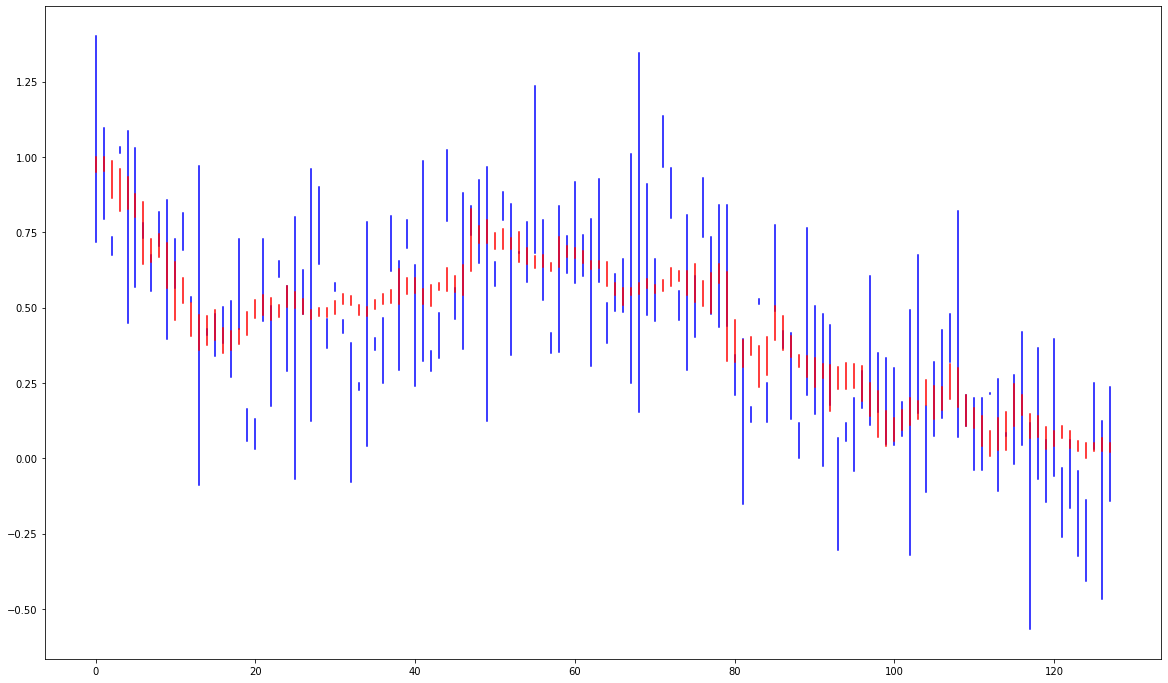

In [133]:
# Candles -> points

@jit(nopython=True, parallel=False)
def candlesToPoints(candles, ds_size=-1):

    point_sequence = candles[:ds_size, 0:2].flatten()                           # create HLHLHL... sequence                              
    
    mask = np.ones(point_sequence.shape, np.bool8)
    
    for i in prange(len(point_sequence)-1):                                     # remove double H/Ls using mask
        if point_sequence[i] == point_sequence[i+1]:
            mask[i] = False
            
    point_sequence = point_sequence[mask]                                       # apply mask
    mask = np.ones(point_sequence.shape, np.bool8)
    
    for i in prange(len(point_sequence)-3):                                     # remove double moves
        if not mask[i]:
            continue
        
        if (point_sequence[i] == point_sequence[i+2]) and (point_sequence[i+1] == point_sequence[i+3]):
            mask[i] = False
            mask[i+1] = False
            
    return point_sequence[mask] 
    

def fixGaps(candles):
  
    candle_count = candles.shape[-1]
    
    for i in range(candle_count-1):
        c1, c2 = candles[i], candles[i+1]
        
        if c2[1] < c1[0]:                       # second candle high is lower than first candle low
            candles[i+1, 1] = c1[0]             # fill the gap
            
        if c2[0] > c1[1]:                       # second candle low is higher than first candle high
            candles[i+1, 0] = c1[1]
    
    return candles





# M1 Candles -> M15 candles
def convertToM15(candles):
    TF = 15
    candles_count = candles.shape[0] // TF      

    tmp = candles[:candles_count*TF]
    
    tmp = np.reshape(tmp, newshape=[candles_count, TF, candles.shape[1]])[:, :, :2]     # split into 15m intervals  (N,15,2)
    tmp = np.reshape(tmp, newshape=[candles_count, TF * 2]) # flatten last two axes to (N, 30), this contains both highs and lows

    lows = np.amin(tmp, axis=-1, keepdims=True)             
    highs = np.amax(tmp, axis=-1, keepdims=True)

    return np.concatenate((lows, highs), axis=1)




@tf.function(jit_compile=True)      # Positional encoding
def int2vec(num, maxNum, dim):
    
    x = tf.cast(num / maxNum * 3.14159265358, dtype=tf.float32)   # 0...2PI
    
    w = tf.range(dim, delta=1, dtype=tf.float32)
    w = tf.math.pow(2.0, w)                         # 1, 2, 4, 8...
    
    return tf.concat([tf.math.sin(x * w), tf.math.cos(x * w)], 0)



@tf.function(jit_compile=False)
def vec2emb(seq, emb_dim=8):
    sequence_length = tf.shape(seq)[0]
    seq = tf.reshape(seq, [-1])
    
    x = tf.cast(seq * 3.14159265358, dtype=tf.float32)   # 0...2PI
    
    w = tf.range(emb_dim, delta=1, dtype=tf.float32)
    w = tf.math.pow(2.0, w)                         # 1, 2, 4, 8...
    
    w = tf.expand_dims(w, axis=0)
    w = tf.tile(w, multiples=(tf.shape(x)[0], 1)) 

    x = tf.expand_dims(x, axis=-1)
    x = tf.tile(x, multiples=(1, emb_dim)) 

    seq = tf.concat([tf.math.sin(x * w), tf.math.cos(x * w)], 1)
    
    seq = tf.reshape(seq, [sequence_length, -1])
    return seq


@tf.function(jit_compile=True)      # Positional encoding 2
def int2bin(inp: tf.Tensor, maxInp: tf.float32, N: tf.int32):

    inp = tf.cast(inp, dtype=tf.float32) 
    maxInp = tf.cast(maxInp, dtype=tf.float32) 

    x = tf.cast(inp / maxInp * tf.math.pow(2.0, N), dtype=tf.int32)   
    
    x_bin = tf.math.floormod(tf.bitwise.right_shift(x, tf.range(N)), 2)
                               
    return tf.reverse(x_bin, axis=[0])    







@tf.function(jit_compile=True)      # Positional encoding 2
def int2binVec(inp: tf.Tensor, maxInp: tf.float32, N: tf.int32):

    sequence_length = tf.shape(inp)[0]
    
    inp = tf.cast(inp, dtype=tf.float32) 
    maxInp = tf.cast(maxInp, dtype=tf.float32) 
    
    x = tf.cast(inp / maxInp * tf.math.pow(2.0, N-1), dtype=tf.int32)   # normalize to integers 0-255 for N=8 

    expanded_range = tf.reshape(tf.range(N), [1, N])
    expanded_range = tf.tile(expanded_range, (sequence_length, 1))      
    
    x = tf.expand_dims(x, axis=-1)
    
    shifted = tf.bitwise.right_shift(x, expanded_range)
    x_bin = tf.math.floormod(shifted, 2)
    
    return tf.reverse(x_bin, axis=[1])      




#@tf.function(jit_compile=False)
def relativePosition(seq, emb_dim=8):
    
    sequence_length = tf.shape(seq)[0]
    seq = tf.reshape(seq, [-1])
    

    pos_indices = tf.range(sequence_length * 2, delta=1, dtype=tf.int32)
    price_indices = tf.argsort(seq, axis=-1)
    
    #print("Position indexes", pos_indices)
    #print("Sorted indices shape", tf.shape(price_indices))

    #print("Seq len", sequence_length)
    
    pos_emb = int2binVec(pos_indices, sequence_length, emb_dim)
    price_emb = int2binVec(price_indices, sequence_length, emb_dim)
    
    #HL_emb = tf.expand_dims(tf.math.mod(pos_indices, 2), axis=-1)    # every second index is a H
    
    #seq = tf.concat([pos_emb, price_emb, HL_emb], 1)
    seq = tf.concat([pos_emb, price_emb], 1)
    
    #seq = tf.reshape(seq, [sequence_length, -1])
    return seq




#@tf.function(jit_compile=False) # random sequencing doesn't work with JIT
def get_random_seq(samples : tf.Tensor) -> tf.Tensor:       

    dataset_size = tf.shape(samples)[0]
    sequence_length = 128
    embedding_size = 8      # bits required to encode every index - log(sequence length * 2)

    i = tf.random.uniform([], minval=0, maxval=dataset_size - sequence_length * 2 - 1, dtype=tf.int32)
     
    seq = samples[i:(i+sequence_length)]
    
    min_val = tf.math.reduce_min(seq)
    max_val = tf.math.reduce_max(seq)
    
    seq = (seq - min_val) / (max_val - min_val + 1e-6)
    
    #flip = tf.random.uniform([], 1, dtype=tf.bool)
    
    #seq = 
    
    seq = relativePosition(seq, embedding_size)
    
    seq = tf.cast(seq, dtype=tf.float32) 

    return seq      # output dim - (sequence_length*2, embedding_size*2+1)



@tf.function(jit_compile=False)
def check_reaction(PA : tf.Tensor, entry : tf.float32, stop : tf.float32):          # exception for unnormalized PA
    """
    PA - normalized to 0-1
    
    """
    
    entry_size = tf.abs(entry-stop)
    tg = entry + entry_size     # only for longs
    
    points = tf.reshape(PA, [-1])


    if tf.reduce_min(PA[0]) < entry:           # longs - wrong levels
        return tf.constant([0.0])
    
    
    if tf.reduce_min(PA) > entry:           # entry level is below the whole PA
        return tf.constant([0.0])
    
    beyond_entry = tf.less(points, entry)
    beyond_stop = tf.less(points, stop)
    beyond_target = tf.greater(points, tg)

   
    entry_index = tf.reduce_min(tf.where(beyond_entry))
    stop_index = tf.reduce_min(tf.where(beyond_stop))
    
    
    if entry_index < 0:
        return tf.constant([0.0])                                # entry not hit -> return
    
    if stop_index < 0:
        stop_index = tf.cast(tf.shape(points)[0], tf.int64)    #tf.constant(tf.shape(points)[0], dtype=tf.int64)       # stop not hit, now check if target got hit
 
    
    target_index = tf.reduce_min(tf.where(beyond_target[entry_index:])) + entry_index    # we have to zero out the PA that happened before entry was hit (entry_index). Because target can get hit before entry has been
    
    
    if target_index < 0:
        target_index = tf.cast(tf.shape(points)[0], tf.int64)     # target not hit
        
        
    if abs(target_index-stop_index) < 2:
        return tf.constant([0.0])     # neither got hit -> filled, but not reached TG yet -> return 0
    
    #if abs(target_index-entry_index) < 2:
    #    return [seq, price_vector, 0.0]     # entry and TG hit inside same candle -> can't tell which was hit first
    
    
    if target_index < stop_index:
        return tf.constant([1.0])     # TG hit first
    else:
        return tf.constant([0.0])    # stop hit first
    

    
##################################################################################################################
##################################################################################################################
##################################################################################################################
##################################################################################################################
##################################################################################################################

    
    

@tf.function(jit_compile=False)
def get_random_trade(samples : tf.Tensor):      
    
    dataset_size = tf.shape(samples)[0]
    sequence_length = 256
    look_ahead_length = 512     # how far in future to look for reaction

    i = tf.random.uniform([], minval=0, maxval=dataset_size - sequence_length * 3 - 1, dtype=tf.int32)
     
    
    PA = samples[i:(i+sequence_length)]
    future_PA = samples[(i+sequence_length):(i+sequence_length+look_ahead_length)]
    
    min_val = tf.math.reduce_min(PA)
    max_val = tf.math.reduce_max(PA)
    
    PA = (PA - min_val) / (max_val - min_val + 1e-6)                      # normalizujeme PA a Future_PA do stejnych souradnic
    future_PA = (future_PA - min_val) / (max_val - min_val + 1e-6)
    
    
    min_stop_size = 0.05
    max_stop_size = 0.2
    
    
    chart_start_price = tf.reduce_min(PA[-1])  # minimum posledni svice ze sekvence
    
    if chart_start_price < 0.5:         # pokud je konec PA (nebo zacatek future_PA) moc blizko k dolni mezi, pak invertujeme svice
        PA = -1.0 * PA + 1.0
        future_PA = -1.0 * future_PA + 1.0
        chart_start_price = tf.reduce_min(future_PA[0]) 
        #tf.print("Inverted!")
    
    

    entry_size = tf.random.uniform([], minval=min_stop_size, maxval=max_stop_size, dtype=tf.float32) * chart_start_price
    entry = tf.random.uniform([], minval=entry_size, maxval=chart_start_price-entry_size, dtype=tf.float32)   # rezerva pro stop a target
    
    stop = entry - entry_size    
     
    res = check_reaction(future_PA, entry=entry, stop=stop)
    
    #tf.print(tf.shape(PA))
    
    return PA, future_PA, res, tf.stack([entry, stop])


########################################3



@tf.function(jit_compile=False) # random sequencing doesn't work with JIT
def get_random_seq_diffusion(samples : tf.Tensor) -> tf.Tensor:       

    dataset_size = tf.shape(samples)[0]
    sequence_length = 128
    max_steps = 200
    std_mod = 0.01

    i = tf.random.uniform([], minval=0, maxval=dataset_size - sequence_length - 1, dtype=tf.int32)
    seq = samples[i:(i+sequence_length)]
    
    min_val = tf.math.reduce_min(seq)
    max_val = tf.math.reduce_max(seq)
    
    seq = (seq - min_val) / (max_val - min_val + 1e-6)
    
    no_embed_seq = seq
    
    #seq = (seq - tf.reduce_mean(seq)) / tf.math.reduce_std(seq)
    
    #seq = vec2emb(seq, emb_dim=8)
    #tf.print(tf.shape(seq))
    #### otput: (sequence_length*2, emb_dim*2)
    
    
    #seq = (seq - tf.reduce_mean(seq)) / tf.math.reduce_std(seq)
    
    step = tf.cast(tf.random.uniform([], minval=1, maxval=max_steps, dtype=tf.int32), tf.float32)
    
    #step = 199.0
    
    alpha_t = 1.0
    for i in tf.range(step):
        alpha_t *= 1.0 - i / tf.cast(max_steps, tf.float32) * std_mod
    
    noise = tf.random.normal(tf.shape(seq), mean=0.0, stddev = 1.0, dtype=tf.float32)
    
    X = tf.sqrt(alpha_t) * seq + tf.sqrt(1.0 - alpha_t) * noise
    
    #min_val = tf.math.reduce_min(X)
    #max_val = tf.math.reduce_max(X)
    #X = (X - min_val) / (max_val - min_val + 1e-6) * 2.0 - 1.0
    
    
    
    #X = (X - tf.reduce_mean(X)) / tf.math.reduce_std(X)
    #X = tf.clip_by_value(X, -8.0, 8.0)
    
    
    return X, noise, step, seq, no_embed_seq


    
    
    
tmp_PA = M15_candles[512:768]

min_val = tf.math.reduce_min(tmp_PA)
max_val = tf.math.reduce_max(tmp_PA) 
    
tmp_PA = (tmp_PA - min_val) / (max_val - min_val + 1e-6)   

entry = 0.095
stop_size = 0.05


#tmp = get_random_trade(M15_candles)  
#tf.print(check_reaction(PA=tmp_PA, entry=entry, stop=entry-stop_size)) 

#x = 0.0

#for i in range(1000):
#    x += check_reaction(PA=tmp_PA, entry=entry, stop=entry-stop_size)


#x, y, result, levels = get_random_trade(M15_candles)
#tf.print(result, levels)
#tf.print(x.shape)

#entry = levels[0]
#stop_size = entry - levels[1]

get_random_seq_diffusion(M15_candles)


#fig = plt.figure(figsize=(20, 12))

#for i in range(x.shape[0]):
#    plt.plot((i, i), (x[i, 0], x[i, 1]), color="blue")
#    plt.plot((i+x.shape[0], i+x.shape[0]), (y[i, 0], y[i, 1]), color="red")


#plt.plot((256, 511), (entry, entry), color="blue")
#plt.plot((256, 511), (entry-stop_size, entry-stop_size), color="red")
#plt.plot((256, 511), (entry+stop_size, entry+stop_size), color="green")



seq_augm, noise, step, orig, no_emb_seq = get_random_seq_diffusion(M15_candles)


fig = plt.figure(figsize=(20, 12))

for i in range(seq_augm.shape[0]):
    plt.plot((i, i), (seq_augm[i, 0], seq_augm[i, 1]), color="blue")
    plt.plot((i, i), (orig[i, 0], orig[i, 1]), color="red")
    #plt.plot((i, i), (noise[i, 0], noise[i, 1]), color="black")
    #plt.plot((i, i), (seq_augm[i, 0] - noise[i, 0], seq_augm[i, 1] - noise[i, 1]), color="black")
    
    
#print(seq_augm[:10, 0])
#print(noise[:10, 0])

tf.print(step, tf.reduce_mean(noise))



#x1 = get_random_seq(M15_candles)
#print(x1)


In [134]:
# M15 dataset



M15_data = tf.data.Dataset.from_tensor_slices([M15_candles])

M15_data = (
    M15_data.repeat()
    .map(get_random_seq_diffusion, num_parallel_calls=16)       # get_random_seq_diffusion, get_random_trade
)

#M15_data = tf.data.Dataset.zip((M15_data, M15_data))


In [11]:
from keras.callbacks import TensorBoard
exp_name = "test_price_AE"

                
callbacks = [EarlyStopping(monitor='loss',
                           patience=400,
                           verbose=1,
                           mode='min'),
             ReduceLROnPlateau(monitor='loss',
                               factor=0.1,
                               patience=100,
                               verbose=1,
                               min_delta=0.00001,
                               mode='min'),
             TerminateOnNaN()]

#%load_ext tensorboard
#%tensorboard --logdir gdrive/Shareddrives/edu_VAD/Anton/VAD_project/logs,   TensorBoard(log_dir= projDir + './logs', histogram_freq=0, write_graph=True)

#              ModelCheckpoint(monitor='accuracy',
#                             filepath= projDir + 'weights/{}'.format(exp_name) + '_{epoch:04d}.hdf5',
#                             save_best_only=False,
#                             save_freq=50,      # every 5 epochs
#                             save_weights_only=True,
#                             mode='max')




In [12]:
# Architecture

with tf.device(DEVICE):

    K.clear_session()

    
    class TransformerBlock(Layer):
        def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
            super(TransformerBlock, self).__init__()

            self.num_heads = num_heads
            self.embed_dim = embed_dim
            self.ff_dim = ff_dim
            self.dropout_rate = rate

            self.att = fast_attention.Attention(num_heads=num_heads, hidden_size=embed_dim, attention_dropout=rate)
            
            self.ffn = Sequential(
                [Dense(ff_dim, activation="ReLU", kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0)),        # LeakyReLU
                 Dense(embed_dim, kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0)),]
            )
            self.layernorm1 = LayerNormalization(epsilon=1e-6)
            self.layernorm2 = LayerNormalization(epsilon=1e-6)
            self.dropout1 = Dropout(rate)
            self.dropout2 = Dropout(rate)

        @tf.function(jit_compile=False, experimental_follow_type_hints=False)
        def call(self, inputs, training=True):
            attn_output = self.att(inputs, inputs, bias=None)
            attn_output = self.dropout1(attn_output, training=training)
            out1 = self.layernorm1(inputs + attn_output)                    # layernorm
            ffn_output = self.ffn(out1)    
            ffn_output = self.dropout2(ffn_output, training=training)
            return self.layernorm2(inputs + out1 + ffn_output)     


        def get_config(self):
            cfg = super(TransformerBlock, self).get_config()
            cfg.update({'num_heads': self.num_heads,
                        'embed_dim': self.embed_dim,
                        'ff_dim': self.ff_dim,
                          'dropout_rate': self.dropout_rate})
            return cfg
        
        
        
    


    class PositionEmbedding(Layer):
        def __init__(self, maxlen, embed_dim):
            super(PositionEmbedding, self).__init__()
            self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)
            self.maxlen = maxlen

        @tf.function(jit_compile=False)
        def call(self, x):
            #maxlen = tf.shape(x)[-1]
            positions = tf.range(start=0, limit=self.maxlen, delta=1)
            positions = self.pos_emb(positions)
            return x + positions

        def get_config(self):
            cfg = super(PositionEmbedding, self).get_config()
            cfg.update({'pos_emb': self.pos_emb,
                        'maxlen': self.maxlen})
            return cfg
        
        
    
    class InstanceNorm(Layer):
        def __init__(self):
            super(InstanceNorm, self).__init__()


        @tf.function(jit_compile=False)
        def call(self, x):

            return (x - tf.reduce_mean(x, axis=0)) / (tf.math.reduce_std(x, axis=0) + 1e-8)





    def FFT_loss_1D(y_true, y_pred):
            
        spec1 = tf.signal.fft(tf.cast(y_true, dtype=tf.dtypes.complex64)) / (y_true.shape[-1] ** 0.5)
        spec2 = tf.signal.fft(tf.cast(y_pred, dtype=tf.dtypes.complex64)) / (y_pred.shape[-1] ** 0.5)

        return  tf.math.reduce_mean(tf.math.log(1.0 + tf.cast(tf.abs(spec1-spec2), dtype=tf.float32))) * 100 


    
        
    
    class InvertedResidual1D(Layer):
        def __init__(self, filters, strides, expansion_factor=2, trainable=True,
                    name=None, **kwargs):
            super(InvertedResidual1D, self).__init__(trainable=trainable, name=name, **kwargs)
            self.filters = filters
            self.strides = strides
            self.expansion_factor = expansion_factor	# allowed to be decimal value
            self.act = tf.nn.leaky_relu  #tf.nn.leaky_relu

        def build(self, input_shape):
            input_channels = int(input_shape[-1])
            
            l2_reg = 0.0
            
            self.ptwise_conv1 = Conv1D(filters=int(input_channels*self.expansion_factor), kernel_size=1, use_bias=True, 
                                       kernel_constraint=max_norm(6.0), bias_constraint=max_norm(6.0))
        
            self.dwise = DepthwiseConv1D(kernel_size=5, strides=self.strides, padding='same', use_bias=True, 
                                        kernel_constraint=max_norm(6.0), bias_constraint=max_norm(6.0))
            
            self.ptwise_conv2 = Conv1D(filters=self.filters, kernel_size=1, use_bias=True, 
                                       kernel_constraint=max_norm(6.0), bias_constraint=max_norm(6.0))

            self.bn1 = LayerNormalization()
            self.bn2 = LayerNormalization()
            
        @tf.function(jit_compile=False)
        def call(self, input_x):

            x = self.ptwise_conv1(input_x)
            x = self.bn1(x)
            x = self.act(x)

            x = self.dwise(x)
            x = self.bn2(x)
            x = self.act(x)

            x = self.ptwise_conv2(x)


            if input_x.shape[1:] == x.shape[1:]:
                x += input_x
            return x

        def get_config(self):
            cfg = super(InvertedResidual1D, self).get_config()
            cfg.update({'filters': self.filters,
                        'strides': self.strides,
                        'expansion_factor': self.expansion_factor})
            return cfg
        
        
        
    class UNetBlock1D(Layer):
        def __init__(self, filters, trainable=True,
                    name=None, **kwargs):
            super(UNetBlock1D, self).__init__(trainable=trainable, name=name, **kwargs)
            self.filters = filters
            #self.act = tf.nn.leaky_relu

        def build(self, input_shape):
                       
            
            self.residual = Conv1D(filters=int(self.filters), kernel_size=1, use_bias=True, 
                                       kernel_constraint=max_norm(6.0), bias_constraint=max_norm(6.0))
            
            self.conv1 = Conv1D(filters=self.filters, kernel_size=3, use_bias=True, padding="SAME",
                                       kernel_constraint=max_norm(6.0), bias_constraint=max_norm(6.0))
            
            self.conv2 = Conv1D(filters=self.filters, kernel_size=3, use_bias=True, padding="SAME",
                                       kernel_constraint=max_norm(6.0), bias_constraint=max_norm(6.0))
            

            self.norm1 = LayerNormalization()
            self.norm2 = LayerNormalization()

        def call(self, input_x):

            x = self.norm1(input_x)
            x = tf.nn.leaky_relu(x)
            x = self.conv1(x)
            
            x = self.norm2(x)
            x = tf.nn.leaky_relu(x)
            x = self.conv2(x)
            
            if input_x.shape[1:-1] == x.shape[1:-1]:
                x += self.residual(input_x)
            
            return x


        def get_config(self):
            cfg = super(UNetBlock1D, self).get_config()
            cfg.update({'filters': self.filters})
            return cfg
    
    
    
    
    
    class RandomMask(Layer):
        def __init__(self, maxLen=64, masked_rate=0.75):
            super(RandomMask, self).__init__()

            self.maskedRate = masked_rate
            self.rnd = tf.random.get_global_generator()
            self.maxLen = maxLen
            self.trainable = False

        #@tf.function(jit_compile=False)
        def call(self, inputs, training=None):
            
            batch_size = tf.shape(inputs)[-3]   # or 0 ?
            mask = self.rnd.uniform(shape=(batch_size, self.maxLen,), minval=0.0, maxval=1.0, dtype=model_dtype)      # stateless_uniform
            mask = tf.cast(tf.math.greater(mask, self.maskedRate), dtype=model_dtype) 
            
            mask = tf.expand_dims(mask, axis=-1)
            mask = tf.tile(mask, multiples=(1, 1, tf.shape(inputs)[-1]))        # expand the last dimension
            
            if training: 
                return tf.math.multiply(inputs, mask), mask
            
            return inputs, tf.ones(tf.shape(inputs))        # ones = no mask


        def get_config(self):
            cfg = super(RandomMask, self).get_config()
            cfg.update({'maskedRate': self.maskedRate,
                        'maxLen': self.maxLen})
            return cfg
        
    
    class RestoreUnmaskedTokens(Layer):
        def __init__(self, maxLen=64):
            super(RestoreUnmaskedTokens, self).__init__()

            self.rnd = tf.random.get_global_generator()
            self.maxLen = maxLen
            self.trainable = False

        @tf.function(jit_compile=False)
        def call(self, inputs, training=None):
            
            reconstructed, original, mask = inputs
            
            rec = tf.math.multiply(reconstructed, 1.0 - mask)
            remain = tf.math.multiply(original, mask)
            
            if training: 
                return rec + remain
            
            return reconstructed


        def get_config(self):
            cfg = super(RestoreUnmaskedTokens, self).get_config()
            cfg.update({'maxLen': self.maxLen})
            return cfg
        
        
    
    class ConstantLayer(Layer):
        def __init__(self, latent_len = 128, embed_dim = 64, trainable=True, name=None, **kwargs):
            super(ConstantLayer, self).__init__(trainable=trainable, name=name, **kwargs)
            self.latent_len = latent_len
            self.embed_dim = embed_dim

        def build(self, input_shape):

            self.latent_array = self.add_weight(
                shape=(self.latent_len, self.embed_dim),
                initializer="random_normal",
                trainable=True,
            )                           
            
            
        def call(self, input_x):
            bs = tf.shape(input_x)[0]
            x = tf.expand_dims(self.latent_array, axis=0)
            
            return tf.tile(x, multiples=(bs, 1, 1))


        def get_config(self):
            cfg = super(ConstantLayer, self).get_config()
            cfg.update({'latent_len': self.latent_len, 
                        'embed_dim': self.embed_dim})
            return cfg
    
    

In [154]:

################################ encoder

inp_dim = 2
sequence_length = 128
embed_dim = 64
core_seq_len = 32
repeat_count = 3

patch_size = 3


inp = Input(shape=[sequence_length, inp_dim])
step = Input(shape=[1])


x = inp    

#x = Reshape([sequence_length // patch_factor, inp_dim * patch_factor])(x)

y = Embedding(input_dim=200, output_dim=8)(step)
y = Reshape([8])(y)
y = RepeatVector(16)(y)
y = Reshape([16, 8])(y)


x128 = Conv1D(32, 3, activation="tanh", padding="same")(x)

x64 = Conv1D(32, 2, strides=2, padding="same")(x128)      # downsample

x64 = UNetBlock1D(32)(x64)
x64 = UNetBlock1D(32)(x64)
x64 = TransformerBlock(32, 4, 128)(x64)
x64 = TransformerBlock(32, 4, 128)(x64)

x32 = Conv1D(32, 2, strides=2, padding="same")(x64)      # downsample

x32 = UNetBlock1D(32)(x32)
x32 = UNetBlock1D(32)(x32)
x32 = TransformerBlock(32, 4, 128)(x32)
x32 = TransformerBlock(32, 4, 128)(x32)

x16 = Conv1D(32, 2, strides=2, padding="same")(x32)      # downsample

x16 = Concatenate(axis=-1)([x16, y]) 

x16 = TransformerBlock(40, 4, 128)(x16)
x16 = TransformerBlock(40, 4, 128)(x16)
x16 = TransformerBlock(40, 4, 128)(x16)
x16 = TransformerBlock(40, 4, 128)(x16)
y16 = TransformerBlock(40, 4, 128)(x16)


y32 = Conv1DTranspose(32, kernel_size=2, strides=2, padding="SAME")(y16)        # upsample
y32 = y32 + x32

y32 = UNetBlock1D(32)(y32)
y32 = UNetBlock1D(32)(y32)
y32 = TransformerBlock(32, 4, 128)(y32)
y32 = TransformerBlock(32, 4, 128)(y32)

y64 = Conv1DTranspose(32, kernel_size=2, strides=2, padding="SAME")(y32)        # upsample
y64 = y64 + x64

y64 = UNetBlock1D(32)(y64)
y64 = UNetBlock1D(32)(y64)
y64 = TransformerBlock(32, 4, 128)(y64)
y64 = TransformerBlock(32, 4, 128)(y64)

y128 = Conv1DTranspose(32, kernel_size=2, strides=2, padding="SAME")(y64)        # upsample
y128 = y128 + x128


x = Dense(64, activation = 'tanh')(y128)
x = Dense(32, activation = 'tanh')(x)
x = Dense(16, activation = 'tanh')(x)
x = Dense(inp_dim, activation = 'linear')(x)




#x = Dense(64, activation = 'LeakyReLU')(x)      # , kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)
#x = Dense(128, activation = 'LeakyReLU')(x)
#x = Dense(32, activation = 'LeakyReLU')(x)

#x = PositionEmbedding(sequence_length // patch_factor, 32)(x)
#x = TransformerBlock(32, 12, 512)(x)

#x = Concatenate(axis=2)([x, y]) 

#x = PositionEmbedding(sequence_length // patch_factor, 40)(x)
#x = TransformerBlock(40, 12, 512)(x)

#x = Conv2D(32, (1, 3), activation="LeakyReLU", padding="same")(x)

#x = Dense(128, activation = 'LeakyReLU')(x)         
#x = Dense(64, activation = 'LeakyReLU')(x)
#x = Dense(inp_dim * patch_factor, activation = 'linear')(x)

#x = Reshape([sequence_length * inp_dim])(x)
#x = LayerNormalization()(x)
x = Reshape([sequence_length, inp_dim])(x)








#x = RestoreUnmaskedTokens()([x, inp, mask])            
#x = Concatenate(axis=2)([x, y]) 
#x = Dense(128, activation = 'LeakyReLU')(x)         

#x = LayerNormalization()(x)

#x = GRU(16, return_sequences=False)(x)

#x = PositionEmbedding(sequence_length, 16)(x)
#x = MultiHeadAttention(num_heads=4, key_dim=16)(y, x)

#x = GRU(16, return_sequences=True)(x)

#x = GlobalMaxPooling1D()(x)







outp = x

encoder = Model([inp, step], outp, name="encoder")


class GCLAMB(LAMB):
    def get_gradients(self, loss, params):  # gradient centralization
        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads


#SWA = tfa.optimizers.SWA
opt = GCLAMB(learning_rate=0.001)



#encoder.compile(optimizer=opt, loss=FFT_loss_1D, metrics=[tf.keras.metrics.MeanSquaredError(), FFT_loss_1D])     # tf.keras.losses.MSE
#encoder.build(input_shape=[None, sequence_length, inp_dim])


encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 128, 2)]     0           []                               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 128, 32)      224         ['input_35[0][0]']               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 64, 32)       2080        ['conv1d_4[0][0]']               
                                                                                                  
 u_net_block1d_60 (UNetBlock1D)  (None, 64, 32)      7392        ['conv1d_5[0][0]']               
                                                                                            

In [155]:
class AEModel(keras.Model):

    def __init__(self, encoder):
        super(AEModel, self).__init__()
        self.model = encoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        #self.rmse = tf.keras.metrics.RootMeanSquaredError(name="RMSE")
        self.acc = tf.keras.metrics.Accuracy(name="Accuracy")
        self.prec = tf.keras.metrics.Precision(name="Precision")
        self.recall = tf.keras.metrics.Precision(name="Recall")

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc, self.prec, self.recall]
    
    
    
    def call(self, inp):
        
        pred = self.model(inp, training=False)
        
        return pred         
    


    def train_step(self, batch):

        x, noise, step, seq, no_emb_seq = batch                            #self.aug(batch)
        
        with tf.GradientTape() as tape:
            pred = self.model([x, step], training=True)
            loss = self.loss(pred, noise)                       # prediting noise
  

        grads_model = tape.gradient(loss, self.model.trainable_variables)

        self.optimizer.apply_gradients(zip(grads_model, self.model.trainable_variables))
        
        self.loss_tracker.update_state(loss)

        
        return {"loss": self.loss_tracker.result(), 
                "accuracy": self.acc.result(), 
                "precision": self.prec.result(), 
                "recall": self.recall.result()}
    

model = AEModel(encoder)

opt = GCLAMB(learning_rate=0.001)
model.compile(optimizer=opt, loss=tf.keras.losses.MeanAbsoluteError())     # "binary_crossentropy", tf.keras.losses.MSE, tf.keras.losses.MeanAbsoluteError(), FFT_loss_1D


#model.build(input_shape=[None, sequence_length, inp_dim])


In [121]:



#x = InvertedResidual(64, (1, 1), expansion_factor=6)(x)
#kernel_constraint=max_norm(2.0)
#x = RestoreUnmaskedTokens()([x, mask_input, mask])
#x = Conv2DTranspose(32, kernel_size=(3, inp_dim), strides=(2, 1), activation="LeakyReLU", kernel_regularizer=l1(l1_reg), bias_regularizer=l1(l1_reg), padding="SAME")(x)
#x = Conv2D(32, (3, inp_dim), activation="LeakyReLU", kernel_regularizer=l1(l1_reg), bias_regularizer=l1(l1_reg), padding="same")(x)
#x = Conv2DTranspose(1, kernel_size=1, strides=1, activation="linear", padding="SAME", dtype='float32')(x)
#x = Cropping1D([0, predict_len])(x)
#x = GlobalAveragePooling1D()(x)
# Dense(32, activation = 'LeakyReLU', kernel_regularizer=l2(0.01))
# Reshape([64, 129])
# Conv1D(32, 9, activation='relu', input_shape=[129])
# Dropout(p)
# BatchNormalization()
# Permute((2, 1), input_shape=(64, 129))
# LSTM(64, return_sequences = True)
# Flatten()
# GRU(64, return_sequences = True)
# Concatenate(axis=1)([x, y]) 
# Reshape([-1, 128])(inp)
#x = Rescaling(scale=1.0/255.0)(x)
#outp = tf.cast(x, tf.dtypes.float16) # Rescaling(scale=255.0)(x)
#x = GaussianNoise(0.2)(x)
#x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
#outp = Dense(len(POSSIBLE_LABELS), activation="softmax")(x)
#x = PositionEmbedding(timesteps, embed_dim)(x)
#x = RandomMask(maxLen=timesteps, masked_rate=0.3)(x)
#x = RepeatVector(28, input_shape=[30])(x)  # 28x vector
#x = TimeDistributed(Dense(28, activation="sigmoid"))(x)
#x = ActivityRegularization(l1=1e-3)(x)
#x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME", activation="selu")

#print(x.shape)

"""
for l in model.layers:
    print(lay.name, lay.output_shape)
"""

'\nfor l in model.layers:\n    print(lay.name, lay.output_shape)\n'

In [156]:
# train
gc.collect()

K.set_value(model.optimizer.learning_rate, 0.001)
batch_size = 64

try:
    batched_DS = M15_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    hist = model.fit(batched_DS, callbacks=callbacks,
                    batch_size = batch_size, epochs = 4000, steps_per_epoch = 50)  # initial_epoch , validation_data=(valX[:32], valX[:32])
    
    plt.plot(hist.history["loss"])
    plt.title("Loss curve")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.show()
except KeyboardInterrupt:
    print("Interrupted")


# Constant -> MAE = 0.316-0.32 with large BS 2048




#model.save_weights(projDir + 'weights/test_2.hdf5')
#model.save(projDir + 'models/' + exp_name)

Epoch 1/4000


Start
(1, 128, 2)
Iter:  199 0.36849616486375764 0.012520887 -0.701701939 1.87777615 std: 0.385058641
Iter:  198 0.3721995503901395 0.0124946581 -0.688367963 1.86034203 std: 0.380117148
Iter:  197 0.37592116997287095 0.0124685662 -0.674874663 1.84284556 std: 0.375189334
Iter:  196 0.37966082913989896 0.0124426093 -0.661571085 1.82563496 std: 0.370362908
Iter:  195 0.38341832876176424 0.0124167893 -0.648260117 1.80861425 std: 0.365605026
Iter:  194 0.38719346504596236 0.0123911053 -0.634972811 1.79177 std: 0.360921115
Iter:  193 0.3909860295324269 0.0123655563 -0.621759236 1.77522278 std: 0.35632202
Iter:  192 0.39479580909014683 0.0123401452 -0.608416498 1.75873852 std: 0.351775
Iter:  191 0.39862258591493016 0.0123148691 -0.59527117 1.74258387 std: 0.347334862
Iter:  190 0.40246613752832566 0.012289729 -0.58198 1.72656858 std: 0.342934281
Iter:  189 0.4063262367777139 0.0122647267 -0.569022179 1.71098292 std: 0.338671595
Iter:  188 0.410202651837579 0.0122398594 -0.555853546 1.6954538

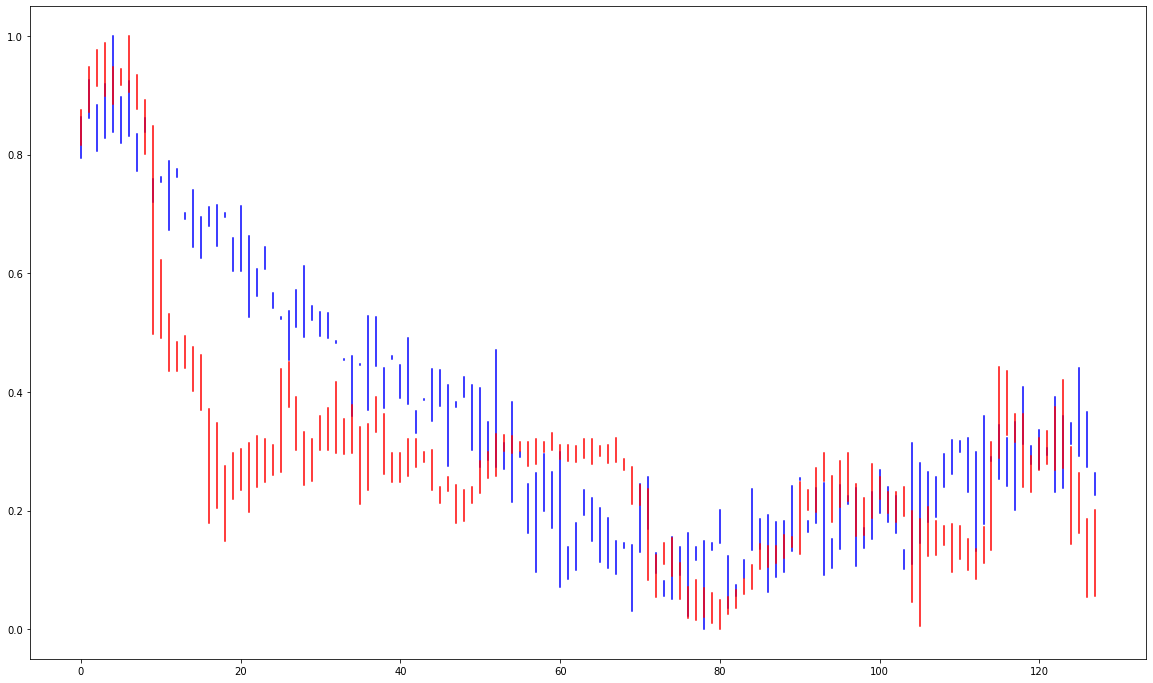

In [149]:

# eval prediction
T = 200     # steps

seq, seq2, step, orig, no_emb_seq = get_random_seq_diffusion(M15_candles)

#sinVec2Float(seq, 8)


#step = tf.expand_dims(tf.expand_dims(step, axis=0), axis=0)

tf.print("Start")
prediction = tf.expand_dims(seq, axis=0)

print(prediction.shape)

alphas = []

beta_t = 0.0      
alpha_t = 1.0
std_mod = 0.01

for k in range(T):
    beta_t = k / T * std_mod
    alpha_t *= 1.0 - beta_t
    alphas.append(alpha_t)
    
    
#print(alphas[:10])

for i in reversed(range(1, T)): 

    
    beta_t = i / tf.cast(T, tf.float32) * std_mod
    step_i = tf.expand_dims(tf.expand_dims(i, axis=0), axis=0)

    
    inv_noise = model([prediction, step_i], training=False) * (beta_t / tf.sqrt(1.0 - alphas[i]))
    prediction = (prediction - inv_noise) / tf.sqrt(1.0 - beta_t) 
    
    
    min_val = tf.math.reduce_min(prediction)
    max_val = tf.math.reduce_max(prediction)
    std = tf.math.reduce_std(prediction)
    
    #prediction = (prediction - min_val) / (max_val - min_val + 1e-6) * 2.0 - 1.0
    
    prediction = tf.clip_by_value(prediction, -8.0, 8.0)
    #prediction = (prediction - tf.reduce_mean(prediction)) / tf.math.reduce_std(prediction)
    
    
    #tf.print("Inv noise std:", tf.math.reduce_std(inv_noise))
    tf.print("Iter: ", i, alphas[i], (beta_t / tf.sqrt(1.0 - alphas[i])), min_val, max_val, "std:", std)
    
min_val = tf.math.reduce_min(prediction)
max_val = tf.math.reduce_max(prediction)
prediction = (prediction - min_val) / (max_val - min_val + 1e-6)

tf.print("End")
prediction = prediction[0]
print(prediction.shape)
#prediction = sinVec2Float(prediction)


#orig_decoded = sinVec2Float(orig)


fig = plt.figure(figsize=(20, 12))
#plt.plot(real_L, color="blue")
#plt.plot(output_L, color="red")

#plt.plot(sample[:, 0], color="blue")
#plt.plot(prediction[:, 0], color="red")

#plt.plot(chart_data[:, 0], color="blue")

for i in range(prediction.shape[0]):
    plt.plot((i, i), (prediction[i, 0], prediction[i, 1]), color="blue")
    plt.plot((i, i), (no_emb_seq[i, 0], no_emb_seq[i, 1]), color="red")





#print("Real:", result)
#print("Pred", prediction)

#for i in range(10):
#    plt.plot(np.squeeze(prediction[i]), color="red")






In [123]:

seq, y, result, levels = get_random_trade(M15_candles)


inp1 = tf.expand_dims(seq, axis=0)
inp2 = tf.expand_dims(levels, axis=0)

for i in batched_DS.take(1):        # jenom jeden batch
    inp1 = i[0]
    inp2 = i[3]
    real = i[2]
    
BS = inp1.shape[0]

prediction = model([inp1, inp2], training=False)

tf.print("Mean result:", tf.reduce_mean(prediction))

round_pred = prediction > 0.31
tf.print("Trades taken:", tf.reduce_sum(tf.cast(round_pred, tf.float32)), "out of", BS)


sum_R = 0.0
for i in range(BS):
    if round_pred[i]:
        sum_R += real[i] 
    
tf.print("Won trades", sum_R)

    
#min_val = tf.math.reduce_min(prediction)
#max_val = tf.math.reduce_max(prediction)
#prediction = (prediction - min_val) / (max_val - min_val + 1e-6)

tf.print("End")

prediction = prediction[0]
print(prediction.shape)



#fig = plt.figure(figsize=(20, 12))


#plt.plot(seq[:])



#for i in range(prediction.shape[0]):
#    plt.plot((i, i), (seq[i, 0], seq[i, 1]), color="blue")
#    plt.plot((i, i), (prediction[i, 0], prediction[i, 1]), color="red")





#print("Real:", result)
#print("Pred", prediction)

#for i in range(10):
#    plt.plot(np.squeeze(prediction[i]), color="red")






InvalidArgumentError: Exception encountered when calling layer "embedding_18" (type Embedding).

indices[80,0,0] = -1 is not in [0, 200) [Op:ResourceGather]

Call arguments received:
  • inputs=tf.Tensor(shape=(256, 128, 2), dtype=float32)

In [284]:
print(prediction)

tf.Tensor(
[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 1. 1.]], shape=(256, 17), dtype=float32)


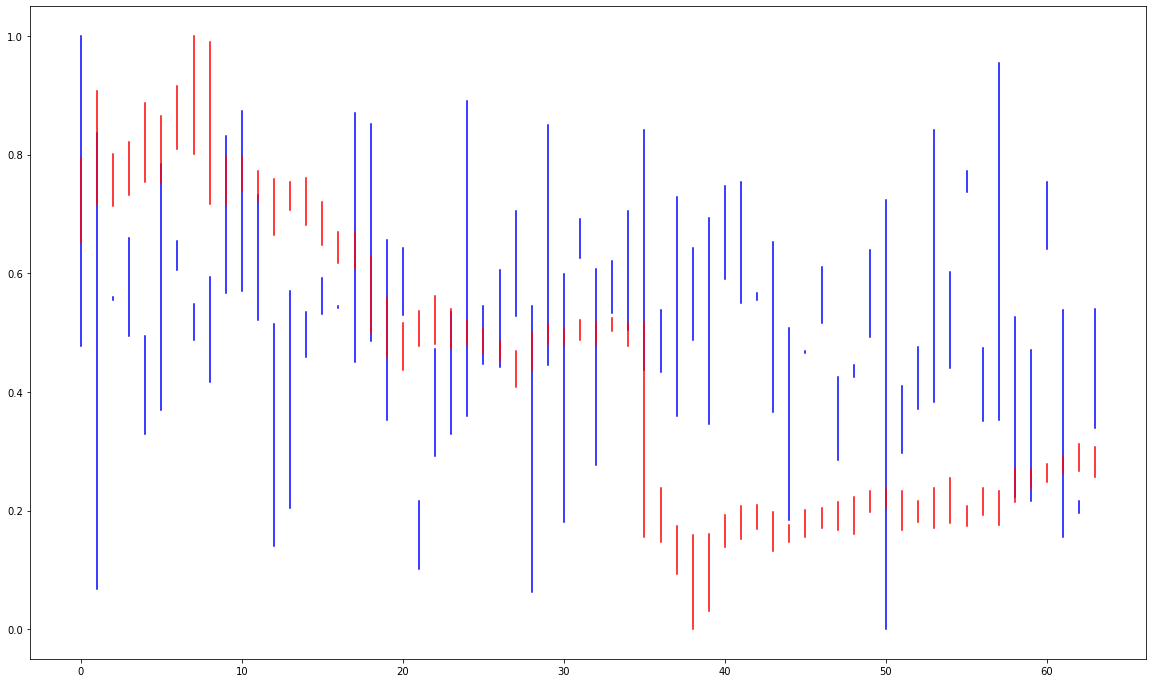

In [124]:



to_denoise, noise, step, orig  = get_random_seq_diffusion(M15_candles)






fig = plt.figure(figsize=(20, 12))


for i in range(prediction.shape[0]):
    plt.plot((i, i), (to_denoise[i, 0], to_denoise[i, 1]), color="blue")
    plt.plot((i, i), (orig[i, 0], orig[i, 1]), color="red")



In [62]:

# eval prediction - show candles

def binVec2Float(input, bin_size):
    vec = np.power(2.0, np.arange(bin_size-1, -1, -1))

    output = []
    for i in input:
        x = np.round_(i) > 0
        output.append(np.dot(vec, x) / 2**bin_size)
    
    return np.array(output)
        
        
sample = get_random_seq(M15_candles)[0]

print(sample.shape)
print(tf.expand_dims(sample, axis=-1).shape)

prediction = model(tf.expand_dims(sample, axis=0), training=True)[0]
#prediction = model.predict(tf.expand_dims(sample, axis=0))[0]
print(sample.shape)

bin_size = 8
N = 3


#output_L = binVec2Float(prediction[:, :bin_size], bin_size)
#output_H = binVec2Float(prediction[:, bin_size:], bin_size)

#real_L = binVec2Float(sample[:, :bin_size], bin_size)
#real_H = binVec2Float(sample[:, bin_size:], bin_size)




fig = plt.figure(figsize=(20, 12))

for i in range(sample.shape[0]):
    plt.plot((i, i), (sample[i, 0], sample[i, 1]), color="blue")
    plt.plot((i, i), (prediction[i, 0], prediction[i, 1]), color="red")







#for i in range(10):
#    plt.plot(np.squeeze(prediction[i]), color="red")
    






InvalidArgumentError: Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: strided_slice/

<Figure size 1440x864 with 0 Axes>

In [45]:
# Load weights


encoder.load_weights("encoder_RNN_64_3")
#encoder.save_weights("encoder_RNN_64_3")

5


In [ ]:
sample = get_random_seq(M15_candles)[0]

print(sample.shape)
print(tf.expand_dims(sample, axis=-1).shape)

prediction = encoder(tf.expand_dims(sample, axis=0), training=True)[0]

print(prediction)




In [ ]:

# Reversed - eval prediction


balance = 1000 # in $
risk = 0.01
RR = 1.0

wins = 0
losses = 0
trades_without_NN = 0



prediction = model.predict(X_reversed_dataset)

print(X_reversed_dataset.shape, prediction.shape)
#print(prediction[0:40])


for i, res in enumerate(Y_data):

    margin = balance * risk
    
    if prediction[i] < 0.5:   # noped by AI
        continue
    
    
    if res == 1:
        balance = balance + margin*RR
        wins = wins+1
        #print(i, "- Win", balance)
    if res == -1:
        balance = balance - margin
        losses=losses+1
        #print(i, "- Loss", balance)
        
        


print("Balance:", balance)
print(wins+losses,"trades taken out of", Y_data.shape[0], "setups")
print("Winrate:", wins / (wins+losses))







In [ ]:





# Show layers output

"""

"""



inp = get_random_seq(M15_candles)
inp = tf.convert_to_tensor(inp, tf.float32)

mdl = encoder
       
layer_outputs = [layer.output for layer in mdl.layers[:]] 
generate = True
if generate:
    for i, l in enumerate(mdl.layers):
        print(i, l.name, l.output_shape)

    get_activations = Model(inputs=mdl.input, outputs=layer_outputs)
    activations = get_activations.predict(inp)



print("All activations:", len(activations))
for i in activations:
    print("Activations:", i.shape, np.amin(i), np.amax(i))
    
    
    
layer_i = 28
print((activations[layer_i][0].T).shape)
print((activations[layer_i][1].T).shape)

x1 = (activations[layer_i][0].T)
x2 = (activations[layer_i][1].T)

x = [np.array(x1), np.array(x2)]


#x = activations[0][0]
#print("x", x.shape)

#print("Min, max: ", np.min(x), np.max(x))
#print("AE: ", x[0, :24, :24])






fig = plt.figure(figsize=(24, 5))

plt.stairs(x[0].T, color="red")
plt.stairs(x[1].T-x[0].T, color="blue")

plt.axis('off')

print("Done")








In [ ]:
print(np.unique(Y_data, return_counts=True))

In [ ]:
# Show output interval

print("### ENCODER ###")
   
layer_outputs = [layer.output for layer in encoder.layers[:]] 

inp = get_random_seq(M15_candles)
inp = tf.convert_to_tensor(inp, tf.float32)


generate = True
if generate:
    get_activations = Model(inputs=encoder.input, outputs=layer_outputs)
    activations = get_activations.predict(inp)
    
print("         Min      Max       SqrtVar   ")
for i, l in enumerate(encoder.layers):
        print("Layer", i, l.name, l.output_shape)
        print("  ", np.min(activations[i][0]), np.max(activations[i][0]), np.sqrt(np.var(activations[i][0])), '\n')



layer_num = 12
x = activations[5:9]
print(x[0].shape)

aspect_ratio = 64 / 16

x_count = 7
y_size = 128 / x_count


fig = plt.figure(figsize=(y_size * aspect_ratio, y_size))

for i, xr in enumerate(x):
    x_shp = x[i][0].shape[0]
    y_shp = x[i][0].shape[2]
    tmp = tf.reshape(x[i][0], (x_shp, y_shp))
    fig.add_subplot(1, 5, i+1)
    plt.imshow(tmp, cmap='gray')
    plt.axis('off')
    




print("Done")









In [ ]:
## show kernels


mdl = encoder

inp = get_random_seq(M15_candles)
inp = tf.convert_to_tensor(inp, tf.float32)

layer_weights = [layer.weights for layer in mdl.layers[:]] 

generate = True
if generate:
    for i, l in enumerate(mdl.layers):
        print(i, l.name, l.output_shape)

    get_weights_model = Model(inputs=mdl.input, outputs=layer_weights)
    weights = get_weights_model.predict(np.expand_dims(inp, axis=0))

layer_num = 10

weights = layer_weights[2]
print(weights)



#print(weights[layer_num].shape)

x = np.array(weights)[0]
x = np.transpose(x, (2, 0, 1, 3))[0]
x = np.transpose(x, (2, 1, 0))   # transpose



aspect_ratio = 64 / 64

x_count = 4
y_size = 32 / x_count


fig = plt.figure(figsize=(y_size * aspect_ratio, y_size))

for i, xr in enumerate(x):
    fig.add_subplot(x.shape[0], x_count, i+1)
    plt.imshow(xr, cmap='gray')
    plt.axis('off')
    


print("Done")





In [ ]:
# Load model


model = load_model(projDir + 'models/' + exp_name)
print('Loaded')

In [ ]:
# save model
exp_name = "Contrastive_1024candles_to_2048_25layer_res_dconv"
model.save_weights(projDir + 'weights/' + exp_name + '.hdf5')
#model.save(projDir + 'models/' + exp_name)

encoder.save_weights(projDir + 'weights/encoder_2048_contrastive.hdf5')
encoder.save(projDir + 'models/encoder_2048_contrastive')


print('Saved')

